In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import sys

sys.path.append(r'C:\Users\danie\Documents\Random Quantum Circuits\Amos efficient code')

from Lib_gen import *

In [2]:
def qSwap(q):
    A=np.zeros((q**2,q**2))
    A[q**2-1][q**2-1]=1
    
    for b in range(q):
        for a in range(q-1):
            if b>a:
                A[a*q+b][b*q+a]=1
                A[b*q+a][a*q+b]=1
            if a==b:
                A[a*q+b][b*q+a]=1
    return A

In [3]:
def TwoGateRanPhase_parity(q,eps): #defining the two site gate with random phases on the diagonal
    """eps = Standard deviation """
    ranphases = np.random.normal(0, eps, q*q)
    #ranphases = 2*np.pi*np.random.rand(q*q)
    diagonals = np.zeros((q**2,q**2),dtype='complex')
    for b in range(q):
        for a in range(q-1):
            if b>a:
                ranphase=ranphases[0]
                diagonals[a*q+b][a*q+b]=np.exp(1j *ranphase)
                diagonals[b*q+a][b*q+a]=np.exp(1j *ranphase)
            if a==b:
                ranphase=ranphases[0]
                diagonals[a*q+b][a*q+b]=np.exp(1j *ranphase)
            ranphases=np.delete(ranphases,[0])
    diagonals[q**2-1][q**2-1]=np.exp(1j *ranphases[0])
    return diagonals#

def OneGateCUE_parity(q,eps): #defining the one site gate with random phases on the diagonal
    ranphases = np.random.normal(0, eps, q)
    diagonals = np.array([[numpy.exp(1j *ranphases[i]) for i in range(0,q)]])
    return scipy.sparse.diags(diagonals, [0])

In [14]:
def W_cue_random_phase_parity(q,L,eps,list=True):
    if L%2==0:
        twogates= [TwoGateRanPhase(q,eps) for i in range(int(L/2-1))]
        
        ### Random Phase
        biglist1=[Sparse2gate_general_multiarg_given_mat(twogates[i-1],q,L,i) for i in range(1,int(L/2))]
        biglist1.append(Sparse2gate_general_multiarg_given_mat(TwoGateRanPhase_parity(q,eps),q,L,int(L/2)))
        for i in range(int(L/2)+1,L):
            A = sparse.csr_matrix.dot(qSwap(q),twogates[L-1-i]) 
            A = sparse.csr_matrix.dot(A,qSwap(q))
            
            biglist1.append(Sparse2gate_general_multiarg_given_mat(A,q,L,i))
        
        ### CUE 1gates:
        onegates = [cue(q) for i in range(int(L/2))]
        biglist2=[Sparse1gate_general_multiarg_given_mat(onegates[i-1],q,L,i) for i in range(1,int(L/2)+1)]
        biglist2=biglist2+[Sparse1gate_general_multiarg_given_mat(onegates[L-i],q,L,i) for i in range(int(L/2)+1,L+1)]
    else:
        twogates= [TwoGateRanPhase(q,eps) for i in range(int((L-1)/2))]
        
        ### Random Phase
        biglist1=[Sparse2gate_general_multiarg_given_mat(twogates[i-1],q,L,i) for i in range(1,int((L-1)/2+1))]
        for i in range(int((L-1)/2+1),L):
            A = sparse.csr_matrix.dot(qSwap(q),twogates[L-1-i]) 
            A = sparse.csr_matrix.dot(A,qSwap(q))
            
            biglist1.append(Sparse2gate_general_multiarg_given_mat(A,q,L,i))
        
        ### CUE 1gates:
        onegates = [cue(q) for i in range(int((L-1)/2))]
        biglist2=[Sparse1gate_general_multiarg_given_mat(onegates[i-1],q,L,i) for i in range(1,int((L-1)/2+1))]
        biglist2.append(Sparse1gate_general_multiarg_given_mat(cue(q),q,L,int((L-1)/2+1)))
        biglist2=biglist2+[Sparse1gate_general_multiarg_given_mat(onegates[L-i],q,L,i) for i in range(int((L+3)/2)+1,L+1)]        
    
    if(list): #if list is True, returns just the list, otherwise the corresponding multiplied matrix
        return biglist1+biglist2

    else:

        temp = biglist2[0]
        for (i,mat) in enumerate(biglist2):
            if not(i==0):
                temp = mat.dot(temp)
            else:
                pass
        for (j,mat) in enumerate(biglist1):
            temp = mat.dot(temp)
        return temp.todense()

In [15]:
circuit = W_cue_random_phase_parity(2,5,1,list=False)

In [ ]:
# Define the system parameters
L = 8  # System size
q = 3   # Quantum dimension
tmax = 1200  # Maximum time
freq = 1   # Time step frequency
repeat=700
eps=0.5
# Generate the quantum circuit

# Initialize time  and SFF arrays
times = np.arange(1, tmax, freq)
sff_values_rpm_parity = np.zeros(len(times))
sff_diff_rpm_parity = np.zeros(len(times), dtype = 'complex_')

# Calculate SFF at each time step
for _ in range(repeat):
    circuit = W_cue_random_phase_parity(q,L,eps,list=False)
    eigenvalues = np.linalg.eigvals(circuit)
    for t in times:
        sff_values_rpm_parity[t-1]+=(np.linalg.norm(np.sum(np.power(eigenvalues,t)))**2)/repeat
        sff_diff_rpm_parity[t-1]+=(2*np.real(np.sum(np.log(eigenvalues)*np.power(eigenvalues,t))*np.sum(np.conjugate(np.power(eigenvalues,t)))))/repeat     
    if _%50==0:
        print('Done 50')

Done 50
Done 50
Done 50
Done 50


In [ ]:
# Plot the SFF as a function of time
fig=plt.figure(figsize=(12,12))
plt.plot(times[1:], sff_values_rpm_parity[1:])

f,residuals,_,_,_ = np.polyfit(np.log(times[1:]), sff_values_rpm_parity[1:], 1,full=True)
plt.plot(times[1:],(f[0]*np.log(times[1:])+f[1]))

plt.xlabel('Time')
plt.ylabel('SFF')
plt.title('SFF vs. Time for Floquet Random Quantum Circuit')
plt.grid(True)
plt.show()

print(f[0],f[1])

In [8]:
def coe(n):
    tmp1=cue(n)
    mat1=np.transpose(tmp1)@tmp1
    return mat1

def W_coe_brickwall(q,L,list=True,pbc_boo=True):
    twogate_func= coe
    func_arg=q**2
    if pbc_boo==True:
        biglist1=[Sparse2gate_general_multiarg(twogate_func,q,L,i,func_arg) for i in range(1,L+1,2)]
        biglist2=[Sparse2gate_general_multiarg(twogate_func,q,L,i,func_arg) for i in range(2,L+1,2)]
    else:
        biglist1=[Sparse2gate_general_multiarg(twogate_func,q,L,i,func_arg) for i in range(1,L,2)]
        biglist2=[Sparse2gate_general_multiarg(twogate_func,q,L,i,func_arg) for i in range(2,L,2)]

    if(list): #if list is True, returns just the list, otherwise the corresponding multiplied matrix
        return biglist1+biglist2

    else:

        temp = biglist1[0]
        for (i,mat) in enumerate(biglist1):
            if not(i==0):
                temp = mat.dot(temp)
            else:
                pass
        for (j,mat) in enumerate(biglist2):
            temp = mat.dot(temp)
        return temp.todense()

In [9]:
# Define the system parameters
L = 10  # System size
q = 2   # Quantum dimension
tmax = 1200  # Maximum time
freq = 1   # Time step frequency
repeat=1000
# Generate the quantum circuit

# Initialize time and SFF arrays
times = np.arange(1, tmax, freq)
sff_values_coe = np.zeros(len(times))
sff_diff_coe = np.zeros(len(times), dtype = 'complex_')

# Calculate SFF at each time step
for _ in range(repeat):
    circuit = W_coe_brickwall(q,L,list=False,pbc_boo=False)
    eigenvalues = np.linalg.eigvals(circuit)
    for t in times:
        sff_values_coe[t-1]+=(np.linalg.norm(np.sum(np.power(eigenvalues,t)))**2)/repeat
        sff_diff_coe[t-1]+=(2*np.real(np.sum(np.log(eigenvalues)*np.power(eigenvalues,t))*np.sum(np.conjugate(np.power(eigenvalues,t)))))/repeat     
    if _%50==0:
        print('Done 50')

Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50
Done 50


C:\Users\danie\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


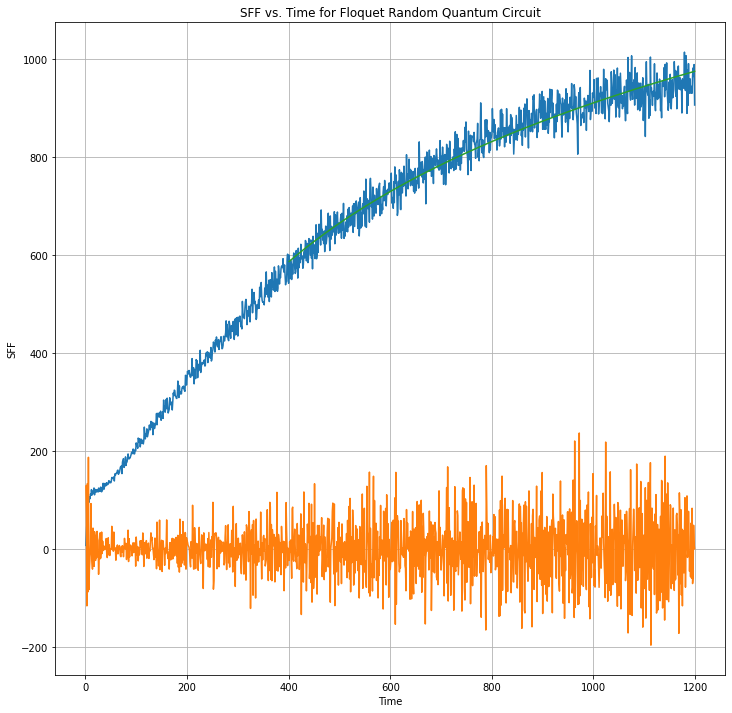

In [10]:
fig=plt.figure(figsize=(12,12))

plt.plot(times, sff_values_coe)
plt.plot(times, sff_diff_coe)
g,residuals,_,_,_ = np.polyfit(np.log(times[400:]), sff_values_coe[400:], 1,full=True)
plt.plot(times[400:],(g[0]*np.log(times[400:])+g[1]))

plt.xlabel('Time')
plt.ylabel('SFF')
plt.title('SFF vs. Time for Floquet Random Quantum Circuit')
plt.grid(True)
plt.show()

In [11]:
print(residuals,g)

[610420.53815885] [  354.29441997 -1537.23970447]
